# Find Label Errors in Multilabel (image) Datasets

This tutorial shows how you can use cleanlab to find potential label errors in multilabel datasets. In such datasets, each instance can be labeled with any of k labels, where k is the total number of different labels in the dataset.  Example applications in NLP include part-of-speech-tagging or entity recognition, which is the focus on this tutorial. Here we use the [CelebA](https://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) which consists a large-scale face attributes dataset with more than 200K celebrity images, each with 40 attribute annotations. We use a subset of the attributes in this tuturial 

- Eyeglasses (Person is wearing glasses)
- Wearing_Earrings (Person is wearing earings)
- Wearing_Hat (Person is wearing hat)
- Wearing_Necklace (Person is wearing a necklace)
- Wearing_Necktie (Person is wearing a necktie)
- No_Beard (beard is present)
- Smiling (Person is smiling)

**Overview of what we'll do in this tutorial:** 

- Find tokens with label issues using `cleanlab.filter.find_label_issues` with `multi_label = True`


<div class="alert alert-info">
Quickstart
<br/>
    
We have `multi_labels` and `pred_probs` from a model trained on an existing data? Run the code below to get improved consensus labels and more information about the quality of your labels and annotators.

<div  class=markdown markdown="1" style="background:white;margin:16px">  
    
```ipython3 
from cleanlab. import get_label_quality_multiannotator

noise_idx = filter.find_label_issues(
        labels=dataset["labels"],
        pred_probs=dataset["pred_probs"],
        multi_label=True,
        return_indices_ranked_by='normalized_margin',
    )
```

    
</div>
</div>

You can use `pip` to install all packages required for this tutorial as follows:

```ipython3
!pip install cleanlab
!pip install torchvision
!

# Make sure to install the version corresponding to this tutorial
# E.g. if viewing master branch documentation:
#     !pip install git+https://github.com/cleanlab/cleanlab.git
```

In [4]:
!wget -nc 'https://cleanlab-public.s3.amazonaws.com/MultilabelClassification/labels.npy'
!wget -nc 'https://cleanlab-public.s3.amazonaws.com/MultilabelClassification/pred_probs.npy'
!wget -nc 'https://cleanlab-public.s3.amazonaws.com/MultilabelClassification/pred_probs.npy'
!wget -nc 'https://cleanlab-public.s3.amazonaws.com/MultilabelClassification/val.csv'

In [6]:
import numpy as np
from cleanlab.filter import find_label_issues
import numpy as np

import torchvision

import matplotlib.pyplot as plt

In [106]:
pred_probs = np.load(open('pred_probs.npy','rb'))

In [119]:
labels= np.load(open('labels.npy','rb'))
data = pickle.load(open("image_val.p",'rb'))

In [110]:

def convert_multilabel_y_to_list(y):
    yl = list()
    for i in range(y.shape[0]):
        yl.append(np.where(y[i,:])[0].tolist())
    return yl    

In [111]:
multi_labels = convert_multilabel_y_to_list(labels)

In [151]:
pred_labels = convert_multilabel_y_to_list(np.array((pred_probs>0.5),np.int32))

In [224]:
issues = find_label_issues(pred_probs=pred_probs,labels=multi_labels,
                           multi_label=True,return_indices_ranked_by='self_confidence')

In [225]:
class_names = ['Eyeglasses',
 'Wearing_Earrings',
 'Wearing_Hat',
 'Wearing_Necklace',
 'Wearing_Necktie',
 'No_Beard',
 'Smiling']

In [226]:
def rep_dl(s):
    q = s.split('/')[-1]
    return '/Users/adityathyagarajan/Downloads/archive-2/img_align_celeba/img_align_celeba/'+q

In [227]:
data2 = np.array([rep_dl(i) for i in data])

In [228]:
def get_label_name(ls):
    return [class_names[i] for i in ls]

In [229]:
pred_label_names = [get_label_name(i) for i in pred_labels]
label_names = [get_label_name(i) for i in multi_labels]

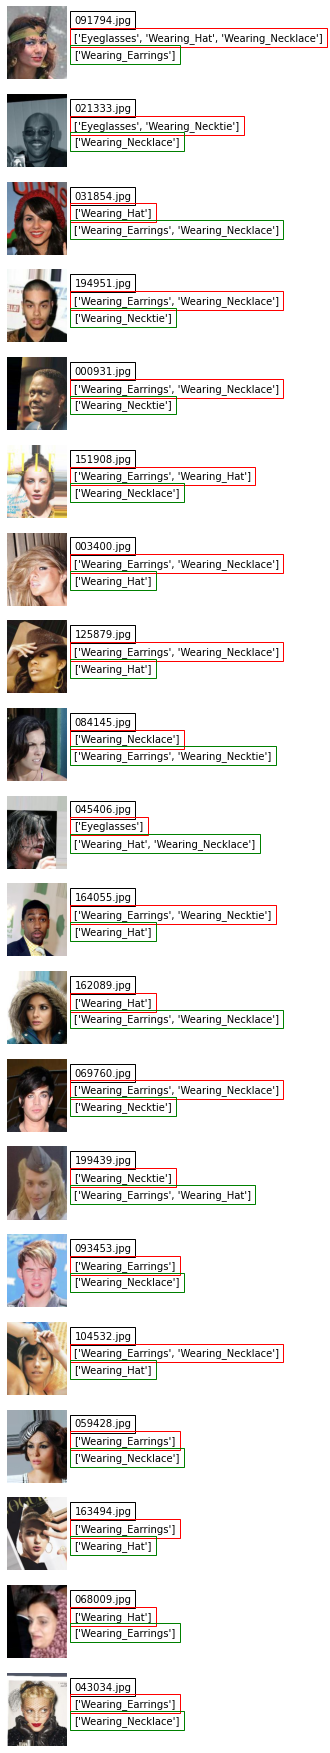

In [230]:
w = 10
h = 10
fig = plt.figure(figsize=(32, 32))
columns = 1
rows = 20
ct=0
for i in range(1, columns*rows +1):
    pos = issues[ct]
    label_error = label_names[pos]
    
    path = data2[pos]
    img = torchvision.io.read_image(path).swapaxes(0,2).swapaxes(0,1)
    fig.add_subplot(rows, columns, i)
    plt.axis('off')
    plt.imshow(img)
    plt.text(200, 50, data2[pos].split('/')[-1], bbox=dict(fill=False, edgecolor='black', linewidth=1))
    plt.text(200, 100, label_error, bbox=dict(fill=False, edgecolor='red', linewidth=1))
    plt.text(200, 150, pred_label_names[pos], bbox=dict(fill=False, edgecolor='green', linewidth=1))
    ct+=1
plt.savefig("errors.pdf")